In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import sys
sys.path.insert(1, '../library')
sys.path.insert(2, '../python_library')

import pyram as pr

import seaborn as sns

from IPython.display import clear_output

Welcome to pyram: your Raman analysis library!


In [2]:
pr.charge_lib('RRUFF_sub')
lib_names = pr.lib_names()

Charging pure spectra library, needs around a minute ....
Done. Good work!


# Import e selezione della libreria

In [3]:
def RRUFF2DF():
    name = ['']*len(lib_names)
    RRUFF_ID = ['']*len(lib_names)
    spectra_type = ['']*len(lib_names)
    wave_length = ['']*len(lib_names)
    spectra = [0]*len(lib_names)
    full_name = ['']*len(lib_names)

    for i in range(len(lib_names)):
        name_t = ''
        RRUFF_ID_t = ''
        spectra_type_t = ''
        wave_length_t = ''
        step = 0

        for j in lib_names[i]:
            if step == 0 and j != '_':
                name_t += j
            elif step == 2 and j != '_':
                RRUFF_ID_t += j
            elif step == 4 and j != '_':
                spectra_type_t += j
            elif step == 6 and j != '_':
                wave_length_t += j
            else:
                step+=1
            
        name[i] = name_t
        RRUFF_ID[i] = RRUFF_ID_t
        spectra_type[i] = spectra_type_t
        wave_length[i] = wave_length_t
        spectra[i] = pr.lib(lib_names[i])
        full_name[i] = lib_names[i]

    global RRUFF_lib
    RRUFF_lib = pd.DataFrame({'name':name, 'RRUFF_ID':RRUFF_ID, 'spectra_type':spectra_type, 'laser':wave_length, 'S':spectra, 'full_name':full_name})
   
    return RRUFF_lib

DB = RRUFF2DF()

display(pd.DataFrame(np.unique(DB.laser, return_counts=True)))
laser = '532'
DB = DB[DB.laser == laser]
DB = DB.reset_index(drop=True)

DB

,0,1,2,3,4,5
0,514,532,780,785,Raman,hase
1,459,2377,920,1118,54,1


,name,RRUFF_ID,spectra_type,laser,S,full_name
0,Abelsonite,R070007,Raman,532,"[[154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 16...",Abelsonite__R070007__Raman__532
1,Actinolite,R040063,Raman,532,"[[119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 12...",Actinolite__R040063__Raman__532
2,Actinolite,R040064,Raman,532,"[[119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 12...",Actinolite__R040064__Raman__532
3,Actinolite,R050025,Raman,532,"[[144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 15...",Actinolite__R050025__Raman__532
4,Actinolite,R050336,Raman,532,"[[141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 14...",Actinolite__R050336__Raman__532
...,...,...,...,...,...,...
2372,Zunyite,R050263,Raman,532,"[[139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 14...",Zunyite__R050263__Raman__532
2373,Zunyite,R050553,Raman,532,"[[147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 15...",Zunyite__R050553__Raman__532
2374,Zwieselite,R050279,Raman,532,"[[136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 14...",Zwieselite__R050279__Raman__532
2375,Zykaite,R070477,Raman,532,"[[148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 15...",Zykaite__R070477__Raman__532


In [6]:
########################################
####### Select subset of elements ######
########################################

all_names =np.unique(DB.name, return_counts=True)
SUB = []
for i in range(len(all_names[0])):
    if all_names[1][i] > 5:
        SUB.append(all_names[0][i])

elements = SUB
#elements = ['Quartz', 'Albite', 'Calcite', 'Dolomite', 'Gypsum', 'Magnesite', 'Talc', 'Forsterite']#,'Chrysotile']
#elements = ['Albite',  'Labradorite', 'Orthoclase']
#elements = ['Tremolite', 'Actinolite']
#elements = ['Clinochlore', 'Vermiculite','Phlogopite']


cond = ''
for i in elements[:-1]:
    cond += 'name == "'+i+'" or '
cond += 'name == "'+elements[-1]+'"'

DB = DB.query(cond)

# Single phase similarity

In [7]:
def get_confusion_similarity(DB):
    DB.reset_index(inplace=True, drop=True)

    names = DB.name
    match = np.zeros((len(names),len(names)))
    
    for i in range(len(names)):
        for j in range(len(names)):
            match[i,j] = pr.cos_sim_w_shift(DB.iloc[i].S, DB.iloc[j].S, shift=3)

    return match

M = get_confusion_similarity(DB)

<AxesSubplot:>

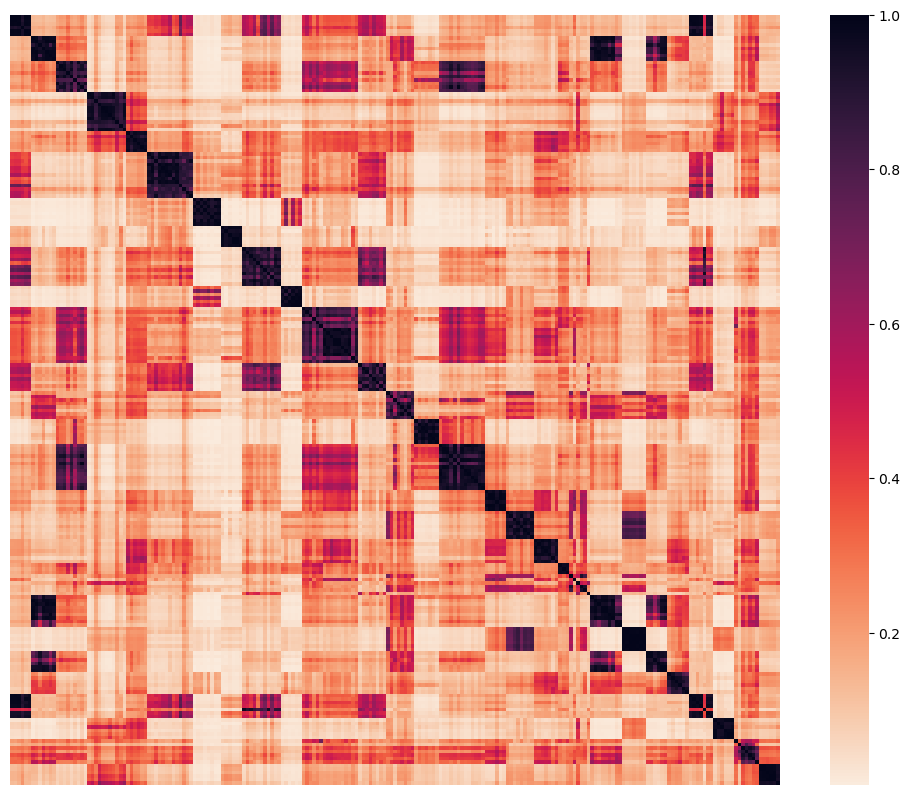

In [8]:
plt.figure(figsize=(13,10))
sns.heatmap(M, cmap = sns.color_palette("rocket_r", as_cmap=True),annot=False, square=True, xticklabels=False, yticklabels=False)

## Train-test split

In [9]:
jump = []
jump += ['Opal']           # Spettri orrendi e tutti diversi, dipende da quanta acqua c'e
jump += ['Pyrope', 'Almandine', 'Spessartine']  #Pyrope forms a solid solution series with almandine and spessartine, which are collectively known as the pyralspite garnets (pyrope, almandine, spessartine).

In [10]:
names = DB.name
ID = DB.RRUFF_ID
ind = np.arange(len(names))

unique = np.unique(DB.name, return_counts=True)
L = len(unique[0])

train = []
test = []

pos=0

for i in range(L):
    if not(np.isin(names[pos], jump)):
       
        train += list(ind[pos:pos+unique[1][i]//2])
        test += list(ind[pos+unique[1][i]//2:pos+unique[1][i]])

    pos+=unique[1][i]

# change library in pyram
dic = {}
for i in train:
    dic[DB.iloc[i].full_name] = DB.iloc[i].S

pr.upload_lib(dic)

## CHECK
for i in pr.lib_names():
    for j in test:
        if i == DB.iloc[j].full_name:
            print('ERROR')
            print(i,' = ',DB.iloc[j].full_name)

## Performances estimation

0.9797979797979798


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

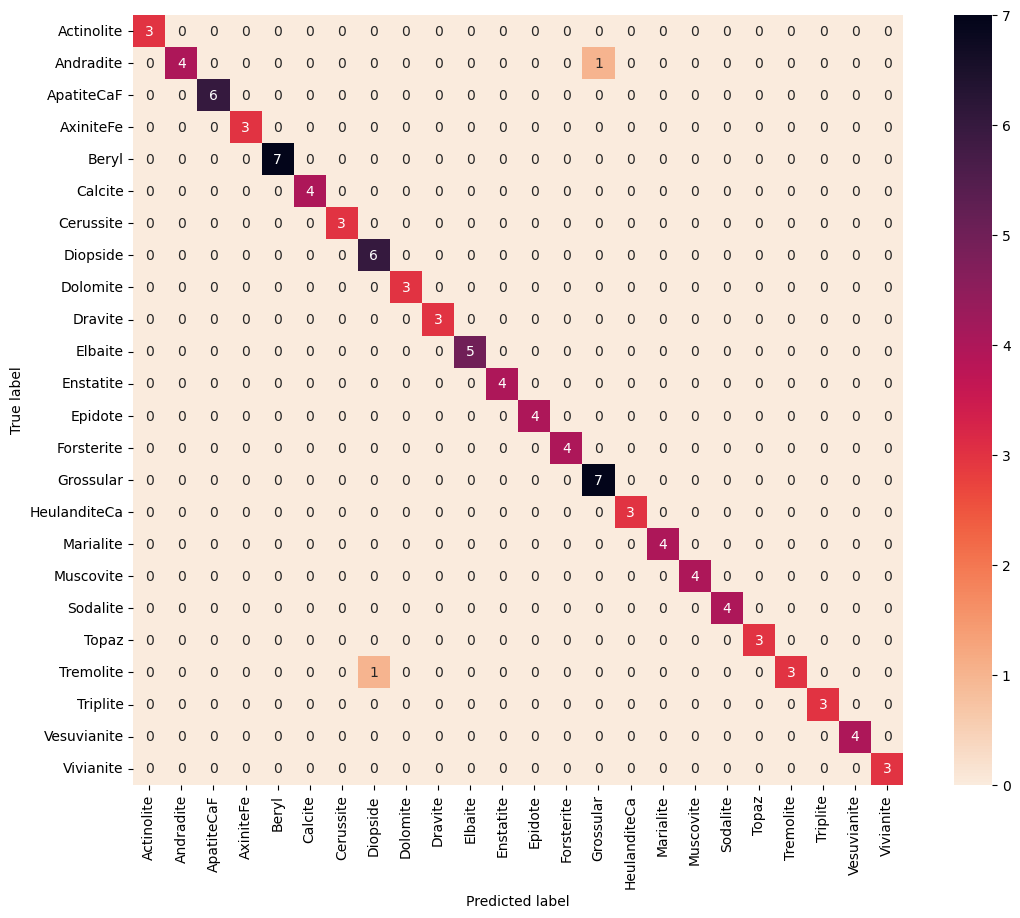

In [11]:
out = []
for i in test:
    pr.search(DB.iloc[i].S, shift=5, verbose=False)
    
    # spectra deconvolution and matching
    search = pr.search(DB.iloc[i].S, shift=3, verbose=False).iloc[0]
    pred_label = search['name']
    sim = search['match']
    
    temp = ''
    for j in pred_label:
        if j != '_':
            temp += j
        else:
            break
    pred_label = temp

    out.append([names[i],pred_label, sim])

out = pd.DataFrame(np.array(out),columns=['True label','Predicted label', 'match'])

# PLOT
plt.figure(figsize=(13,10))
tab = pd.crosstab(out['True label'], out['Predicted label'])
print(np.diag(tab).sum() / tab.to_numpy().sum())
sns.heatmap(tab, cmap = sns.color_palette("rocket_r", as_cmap=True),annot=True, square=True)

# ND

In [12]:
def Ss2commonwn(Ss):
    min = 0
    max = 1e10
    for i in Ss:
        if i[0].min() > min:
            min = i[0].min()
        if i[0].max() < max:
            max = i[0].max()

    wn = np.arange(min,max+1)

    for i in range(len(Ss)):   
        cond = np.isin(Ss[i][0],wn)
        Ss[i] = Ss[i][:,cond]

    return Ss

## Example

trying N = 1 ; resulting in 11 combinations
trying N = 2 ; resulting in 55 combinations
trying N = 3 ; resulting in 165 combinations
best at N = 2


,combination,match
0,"[Diopside__R050496__Raman__532, HeulanditeCa__...",0.989022
1,"[Diopside__R050496__Raman__532, HeulanditeCa__...",0.986445
2,"[Diopside__R050666__Raman__532, HeulanditeCa__...",0.971087
3,"[Diopside__R050666__Raman__532, HeulanditeCa__...",0.970867
4,"[Actinolite__R050025__Raman__532, HeulanditeCa...",0.899946
5,"[Actinolite__R050025__Raman__532, HeulanditeCa...",0.899140
6,"[AxiniteFe__R040074__Raman__532, HeulanditeCa_...",0.845671
7,"[Elbaite__R050487__Raman__532, HeulanditeCa__R...",0.843479
8,"[AxiniteFe__R040074__Raman__532, HeulanditeCa_...",0.843046
9,"[Elbaite__R050487__Raman__532, HeulanditeCa__R...",0.841085


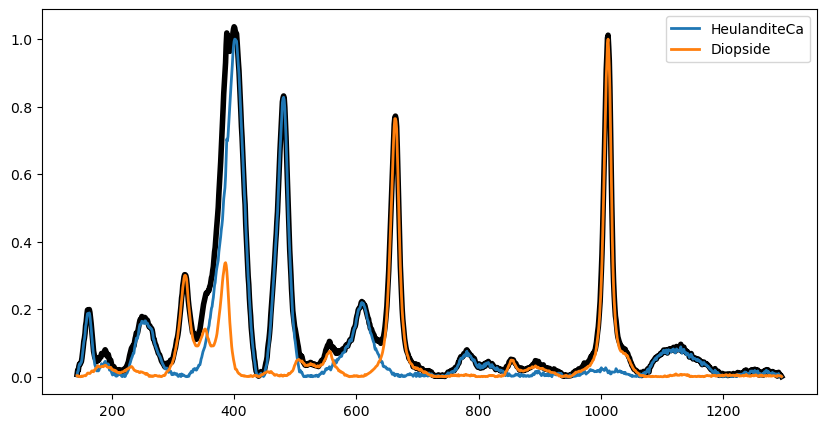

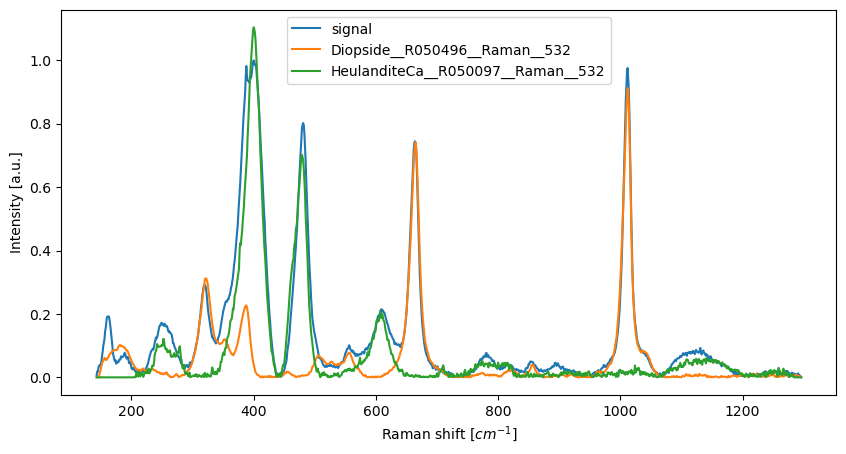

In [14]:
########################################
N = 2
c = 1
########################################

# random pick of spectra
rand_ID = np.random.choice(test, N, replace=False)
while len(np.unique(list(names[rand_ID]))) != N:
    rand_ID = np.random.choice(test, N, replace=False)
Ss = []
for i in rand_ID:
    Ss.append(DB.iloc[i].S)

# reduction to common wavenumber
Ss = Ss2commonwn(Ss)

# normalization to unitary hight
for i in range(N):
    Ss[i][1] = Ss[i][1]/np.max(Ss[i][1])

# generate multiphase spectra
S_test = np.copy(Ss[0])
for i in Ss[1:]:
    S_test[1] += c * i[1]

# plot
plt.figure(figsize=(10,5))
plt.plot(S_test[0],S_test[1], color = 'black', linewidth=4)

for i in range(N):
    plt.plot(Ss[i][0],Ss[i][1], label = DB.iloc[rand_ID[i]]['name'], linewidth=2)

plt.legend()
pr.NDsearch(S_test, set_min=130, set_max=1400, shift=5, improvement_th=0.05)

## Recursive

In [25]:
########################################
N = 3
########################################

out = []
for i in range(1000):
    # random pick of spectra
    rand_ID = np.random.choice(test, N, replace=False)
    while len(np.unique(list(names[rand_ID]))) != N:
        rand_ID = np.random.choice(test, N, replace=False)

    Ss = []
    t = []
    for i in rand_ID:
        Ss.append(DB.iloc[i].S)
        t.append(DB.iloc[i]['name'])

    # reduction to common wavenumber
    Ss = Ss2commonwn(Ss)

    # normalization to unitary hight
    for i in range(N):
        Ss[i][1] = Ss[i][1]/np.max(Ss[i][1])

    # generate multiphase spectra
    S_test = np.copy(Ss[0])
    for i in Ss[1:]:
        S_test[1] += i[1]

    
    temp = pr.NDsearch(S_test, set_min=130, set_max=1400, shift=5, improvement_th=0.05, verbose=False).iloc[0]
    plt.show()
    clear_output()
    out.append([t, temp['combination'], temp['match']])

# sistemo i nomi
for i in range(len(out)):
    for j in range(len(out[i][1])):

        temp = ''
        for k in out[i][1][j]:
            if k != '_':
                temp += k
            else:
                break

        out[i][1][j] = temp


out = pd.DataFrame(out, columns=['True label','Predicted label', 'match'])

[0 1 2 3]
[  3  86 429 482]


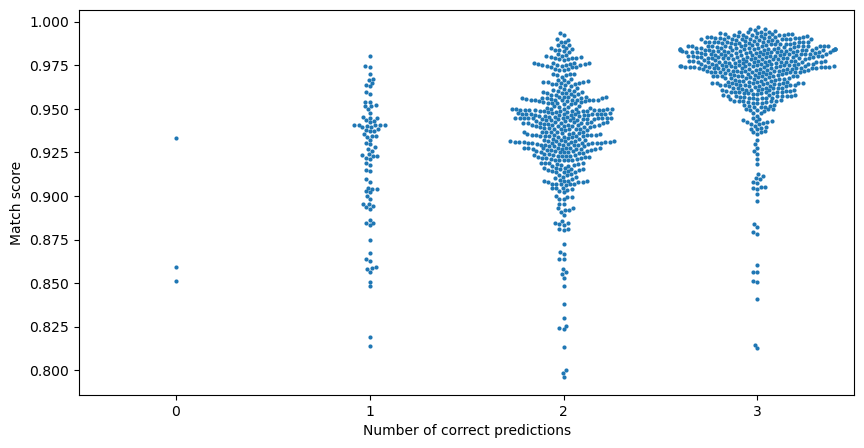

In [27]:
##################################
######## Elaboro risultato #######
##################################

score = [0] * len(out) 
for el in range(len(out)):
    for i in out.iloc[el]['True label']:
        if np.isin(i, out.iloc[el]['Predicted label']):
            score[el] += 1

print(np.unique(score, return_counts=True)[0])
print(np.unique(score, return_counts=True)[1])

plt.figure(figsize=(10,5))
sns.swarmplot(x = score, y = out['match'], size = 3)
plt.xlabel('Number of correct predictions')
plt.ylabel('Match score');